#Imports

In [1]:
"""
This mounts the google drive location for training file folders
"""

from google.colab import drive 
drive.mount('/content/drive',)

Mounted at /content/drive


In [2]:
"""
Includes the necessary imports for working with images, PyTorch, 
    data loading, data transformations, evaluation metrics, numerical operations, plotting,
    and file operations.
"""

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil


In [3]:

"""
The hyperparameters define the batch size, learning rate, number of epochs, 
  and the device to be used (GPU if available, otherwise CPU) for training the model.
"""

# Define hyperparameters
#batch_size = 64
batch_size = 32
learning_rate = 0.001
num_epochs = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


"""
The PlumeDataset class is a custom PyTorch dataset class. 
It takes the paths to the plume and no-plume image directories and an optional transform as inputs. 
It loads the images and their corresponding labels/targets, and provides the methods __len__ and __getitem__ for accessing the dataset.
"""

# Define dataset class
class PlumeDataset(Dataset):
    def __init__(self, plume_dir, no_plume_dir, transform=None):
        self.plume_images = [os.path.join(plume_dir, img) for img in os.listdir(plume_dir)]
        self.no_plume_images = [os.path.join(no_plume_dir, img) for img in os.listdir(no_plume_dir)]
        self.images = self.plume_images + self.no_plume_images
        self.targets = [1] * len(self.plume_images) + [0] * len(self.no_plume_images)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('L')
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, target


"""
The train_transforms and test_transforms are instances of torchvision.transforms.Compose that define a sequence of image transformations
   to be applied to the training and test datasets, respectively. These transforms include random horizontal and vertical flips, random rotation, 
   converting the image to a tensor, and normalizing the image.
"""


# Define data transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])




#Dataloaders

The original dataset contained 214 images containing a methane plume, and 214 images not containing a methane plume. Now, to train our model we created four additional folders. The plume_training folders contain 192 images containg a methane plume and the no_plume_training folder has 192 images not containing a methane plume. The plume_testing folders contain 22 images containg a methane plume and the no_plume_testing folder contains 22 images not containing a methane plume selected manually at random.

In [4]:
"""
The train_dataset and test_dataset are instances of the PlumeDataset class that represent the training and test datasets, respectively. 

They are created by providing the paths to the plume and no-plume image directories and the corresponding transforms. 

The train_loader and test_loader are instances of torch.utils.data.DataLoader that wrap the datasets and provide iterable dataloaders
   for batch processing during training and evaluation.

"""

train_dataset = PlumeDataset('/content/drive/MyDrive/QB/images/plume_training', '/content/drive/MyDrive/QB/images/no_plume_training', transform=train_transforms)
test_dataset = PlumeDataset('/content/drive/MyDrive/QB/images/plume_testing', '/content/drive/MyDrive/QB/images/no_plume_testing', transform=test_transforms)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


"""
The PlumeCNN class is a custom CNN model defined using PyTorch's nn.Module. 

It consists of convolutional layers, batch normalization, max pooling, fully connected layers, dropout, and activation functions. 

The forward() method defines the forward pass of the model.
"""

# Define CNN model
class PlumeCNN(nn.Module):
    def __init__(self):
        super(PlumeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.pool(self.bn1(nn.functional.relu(self.conv1(x))))
        x = self.pool(self.bn2(nn.functional.relu(self.conv2(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = nn.functional.sigmoid(self.fc2(x))
        return x


In [5]:
"""
Initialize the model, loss criterion and optimizer for training.

"""

# Initialize model and optimizer
model = PlumeCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
"""
Evaluates the performance of the model on the given data loader.

Args:
    model (nn.Module): The trained neural network model.
    loader (DataLoader): The data loader for evaluation.

Returns:
    accuracy (float): The accuracy of the model.
    auc_score (float): The Area Under the ROC Curve (AUC) score of the model.
"""


def evaluate(model, loader):
    model.eval()
    targets = []
    #Obtain a list of prediction scores. If the prediction score >= 0.5, it means the image contains a plume, else not
    predictions = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).squeeze()
            predictions += outputs.cpu().tolist()
            targets += labels.cpu().tolist()
    #accuracy = np.mean(np.array(predictions) > 0.5) * 100
    accuracy = accuracy_score(targets, [round(p) for p in predictions])
    auc_score = roc_auc_score(targets, predictions) * 100
    return accuracy, auc_score


#Training the model and get test accuracy and AUC score

In [7]:
import matplotlib.pyplot as plt

# Lists to store the loss and AUC scores
train_losses = []
test_losses = []
auc_scores = []
test_acc = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    test_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_dataset)
    test_accuracy, test_auc_score = evaluate(model, test_loader)
    
    # Store the loss and AUC score for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    auc_scores.append(test_auc_score)
    test_acc.append(test_accuracy)

    if(test_auc_score>=88):
        best_model_dir="/content/drive/MyDrive/QB/models/model_Epoch_"+str(epoch)+"_AUC_"+str(test_auc_score)+"_acc_"+str(test_accuracy)+".pt"
        torch.save(model.state_dict(), best_model_dir)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}, Test AUC: {test_auc_score:.2f}%")



Epoch 1/60, Train Loss: 1.4833, Test Accuracy: 0.64, Test AUC: 67.98%
Epoch 2/60, Train Loss: 0.7220, Test Accuracy: 0.59, Test AUC: 68.60%
Epoch 3/60, Train Loss: 0.6472, Test Accuracy: 0.59, Test AUC: 63.43%
Epoch 4/60, Train Loss: 0.6179, Test Accuracy: 0.64, Test AUC: 65.08%
Epoch 5/60, Train Loss: 0.5500, Test Accuracy: 0.64, Test AUC: 63.02%
Epoch 6/60, Train Loss: 0.6046, Test Accuracy: 0.61, Test AUC: 61.78%
Epoch 7/60, Train Loss: 0.5991, Test Accuracy: 0.59, Test AUC: 58.88%
Epoch 8/60, Train Loss: 0.5595, Test Accuracy: 0.68, Test AUC: 70.45%
Epoch 9/60, Train Loss: 0.6187, Test Accuracy: 0.68, Test AUC: 72.93%
Epoch 10/60, Train Loss: 0.5824, Test Accuracy: 0.61, Test AUC: 70.87%
Epoch 11/60, Train Loss: 0.5476, Test Accuracy: 0.64, Test AUC: 70.04%
Epoch 12/60, Train Loss: 0.5348, Test Accuracy: 0.66, Test AUC: 69.83%
Epoch 13/60, Train Loss: 0.5423, Test Accuracy: 0.70, Test AUC: 70.87%
Epoch 14/60, Train Loss: 0.5198, Test Accuracy: 0.70, Test AUC: 74.17%
Epoch 15/60, Tr

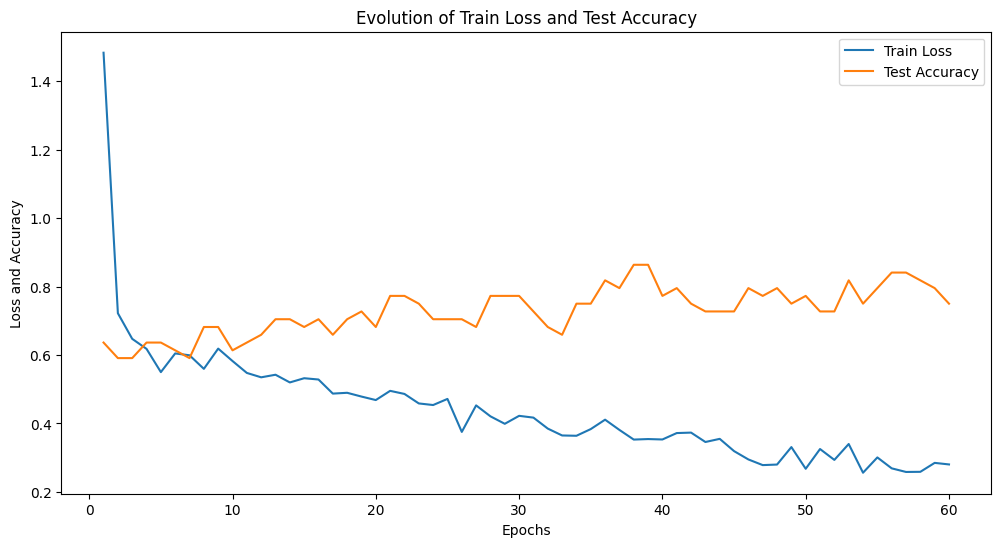

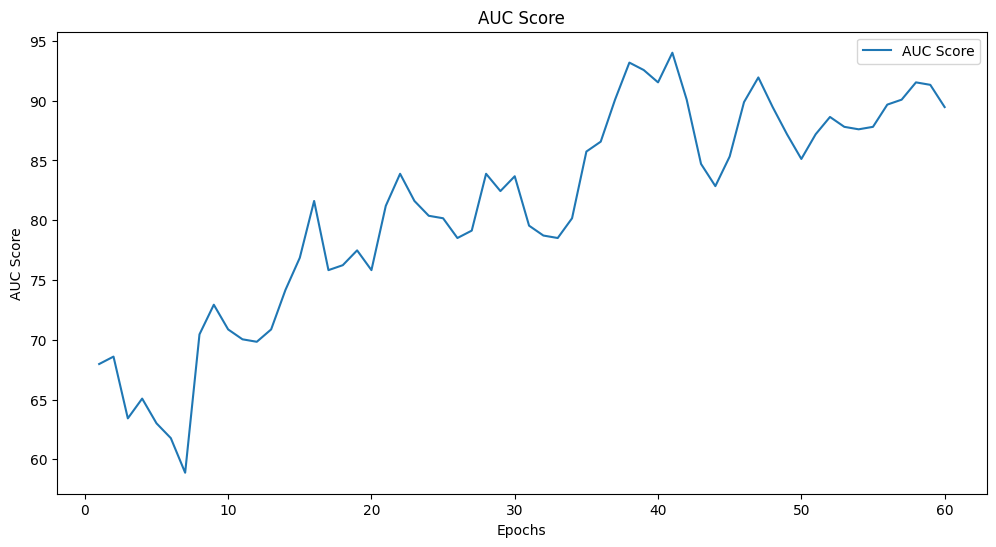

In [8]:
"""
Visualizing model performance and training
"""

# Plotting the training loss and test loss
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy')
plt.title('Evolution of Train Loss and Test Accuracy')
plt.legend()
plt.show()

# Plotting the AUC score
plt.figure(figsize=(12, 6))
plt.plot(epochs, auc_scores, label='AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.title('AUC Score')
plt.legend()
plt.show()

#Upload a folder, get classification score and export the results in a .csv file

In [56]:
"""
Generate a TestDataset class for reading and pre-processing test images
"""

class TestDataset(Dataset):
    def __init__(self, image_loc, transform=None):
        self.image_loc = image_loc
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = Image.open(self.image_loc).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

"""
Generate test_transform object

"""

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [58]:
"""
Create a list of image paths in testing directory

"""
test_dir = '/content/drive/MyDrive/QB/test data/images'
test_image_dir = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
print(test_image_dir)

['/content/drive/MyDrive/QB/test data/images/20230404_methane_mixing_ratio_id_6675.tif', '/content/drive/MyDrive/QB/test data/images/20230110_methane_mixing_ratio_id_9482.tif', '/content/drive/MyDrive/QB/test data/images/20230314_methane_mixing_ratio_id_2274.tif', '/content/drive/MyDrive/QB/test data/images/20230109_methane_mixing_ratio_id_0765.tif', '/content/drive/MyDrive/QB/test data/images/20230115_methane_mixing_ratio_id_2863.tif', '/content/drive/MyDrive/QB/test data/images/20230207_methane_mixing_ratio_id_5491.tif', '/content/drive/MyDrive/QB/test data/images/20230204_methane_mixing_ratio_id_5491.tif', '/content/drive/MyDrive/QB/test data/images/20230210_methane_mixing_ratio_id_2774.tif', '/content/drive/MyDrive/QB/test data/images/20230121_methane_mixing_ratio_id_3733.tif', '/content/drive/MyDrive/QB/test data/images/20230120_methane_mixing_ratio_id_6551.tif', '/content/drive/MyDrive/QB/test data/images/20230328_methane_mixing_ratio_id_6426.tif', '/content/drive/MyDrive/QB/test

In [68]:
"""

Generating predictions for the test images

"""

test_output = {}
test_output['path'] = []
test_output['prediction_score'] = []

for idx, image_loc in enumerate(test_image_dir):
  test_dataset = TestDataset(os.path.join(image_loc),  transform=test_transforms)
  test_loader = DataLoader(test_dataset, batch_size= len(test_dataset) , shuffle=False)

  with torch.no_grad():
    for images in test_loader:
        images = images.to(device)

        # If sigmoid_output >= 0.5, then positive, else negative
        output = model(images).squeeze(0)
        print("Output:")
        print(output)

        test_output['path'].append('/'.join(test_image_dir[idx].split('/')[5:8]))
        test_output['prediction_score'].append(output[0].item())

        predictions = torch.round(output)
        print("Predictions:")
        print(predictions)

        print(f'The image {idx+1} is classified as {"Positive" if predictions[0].item()==1 else "Negative"}.')
        print(f'Prediction score: {output[0].item():.4f}')
        print()

Output:
tensor([0.9793], device='cuda:0')
Predictions:
tensor([1.], device='cuda:0')
The image 1 is classified as Positive.
Prediction score: 0.9793

Output:
tensor([0.9268], device='cuda:0')
Predictions:
tensor([1.], device='cuda:0')
The image 2 is classified as Positive.
Prediction score: 0.9268

Output:
tensor([0.3491], device='cuda:0')
Predictions:
tensor([0.], device='cuda:0')
The image 3 is classified as Negative.
Prediction score: 0.3491

Output:
tensor([0.2507], device='cuda:0')
Predictions:
tensor([0.], device='cuda:0')
The image 4 is classified as Negative.
Prediction score: 0.2507

Output:
tensor([0.0721], device='cuda:0')
Predictions:
tensor([0.], device='cuda:0')
The image 5 is classified as Negative.
Prediction score: 0.0721

Output:
tensor([0.3338], device='cuda:0')
Predictions:
tensor([0.], device='cuda:0')
The image 6 is classified as Negative.
Prediction score: 0.3338

Output:
tensor([0.3330], device='cuda:0')
Predictions:
tensor([0.], device='cuda:0')
The image 7 is 

In [69]:
"""
Reading and Exporting test prediction output dataframe

"""

import pandas as pd
test_output_df = pd.DataFrame(test_output)
test_output_df.head()

,path,prediction_score
0,test data/images/20230404_methane_mixing_ratio...,0.979257
1,test data/images/20230110_methane_mixing_ratio...,0.926756
2,test data/images/20230314_methane_mixing_ratio...,0.349053
3,test data/images/20230109_methane_mixing_ratio...,0.250709
4,test data/images/20230115_methane_mixing_ratio...,0.072056


In [70]:
test_output_df.to_csv('team5.csv')

#Upload one image and get the classification score

In [ ]:
# image_path = '/content/20230126_methane_mixing_ratio_id_4456.tif'
# destination_empty_directory = "/content/drive/MyDrive/QB/empty_directory"

# # Create the destination directory if it doesn't exist
# os.makedirs(destination_empty_directory, exist_ok=True)

# # Copy the image to the destination directory
# shutil.copy2(image_path, destination_empty_directory)

# val_dataset = ValidationDataset(destination_empty_directory,  transform=test_transforms)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# # Load the saved model
# model = PlumeCNN()
# model.load_state_dict(torch.load("/content/drive/MyDrive/QB/models/model_Epoch_40_AUC_89.87603305785123_acc_0.8181818181818182.pt"))
# # Move the model to the same device as the input tensor
# model.to(device)
# model.eval()

# # Iterate over each image in the folder
# for images in val_loader:
#     images = images.to(device)

#     # If sigmoid_output >= 0.5, then positive, else negative
#     output = model(images).squeeze()
#     print("Output:")
#     print(output)

#     predictions = torch.round(output)
#     print("Predictions:")
#     print(predictions.item())  # Convert to Python scalar

#     # Print the classification result for the image
#     print(f'The image is classified as {"Positive" if predictions.item()==1 else "Negative"}.')
#     print(f'Prediction score: {output.item():.4f}')
#     print()




Output:
tensor(0.0006, device='cuda:0', grad_fn=<SqueezeBackward0>)
Predictions:
0.0
The image is classified as Negative.
Prediction score: 0.0006



In [ ]:
# #Delete the image from the empty directory folder
# # Get the list of files in the folder
# files = os.listdir(destination_empty_directory)

# # Iterate over the files and delete each one
# for file in files:
#     file_path = os.path.join(destination_empty_directory, file)
#     if os.path.isfile(file_path):
#         os.remove(file_path)